## Multivariate Forecasting Using scikit-learn ML Models

In [1]:
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import optuna
from models import SKDirect, ForecastPipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import models
import importlib
importlib.reload(models)
from models import *
from data import update_expl_data, update_target_data, food_categories

In [2]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]

## Load Data Sources

In [3]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2020-04-01,158.7,142.8,144.4,159.2,154.0,138.8,170.0,139.8,160.3
2020-05-01,160.2,142.8,149.0,159.3,154.3,138.3,173.5,139.1,157.9
2020-06-01,158.9,142.1,145.7,159.5,154.8,139.0,177.0,137.8,163.1


In [4]:
"""
Load exogenous/auxiliary explanatory variables from FRED: https://fred.stlouisfed.org/
These data sources reflect various economic factors that may improve forecasts. 
Please visit the FRED website to learn more about these series, and to find others
that may be useful for food CPI forecasting. 
"""

data_sources = ["DEXCAUS",
                "DCOILWTICO",
                "WILL5000IND",
                "VXOCLS",
                "CUSR0000SAF112",
                "CUSR0000SAF113",
                "CPIFABSL",
                "UNRATE",
                "FEDFUNDS",
                "IRLTLT01CAM156N",
                "LRUNTTTTCAM156S",
                "CPALCY01CAM661N",
                "CPGRLE01CAM657N",
                "QCAR368BIS"
               ]
expl_df = preprocess_expl(update_expl_data(data_sources, './data_files/expl_vars.csv'))
expl_df_monthly = expl_df.resample(frequency).mean().interpolate()
expl_df_monthly

,DEXCAUS,DCOILWTICO,WILL5000IND,VXOCLS,CUSR0000SAF112,CUSR0000SAF113,CPIFABSL,UNRATE,FEDFUNDS,IRLTLT01CAM156N,LRUNTTTTCAM156S,CPALCY01CAM661N,CPGRLE01CAM657N,QCAR368BIS
1986-01-01,1.39,11.13,5.53,24.70,102.50,110.40,107.50,6.7,8.14,10.04,10.0,52.29,0.19,8.76
1986-02-01,1.39,11.13,5.53,24.70,102.00,105.30,107.40,7.2,7.86,9.97,10.0,52.53,0.72,9.85
1986-03-01,1.39,11.13,5.53,24.70,101.90,105.90,107.60,7.2,7.48,9.40,9.9,52.85,0.76,10.95
1986-04-01,1.39,11.13,5.53,24.70,101.10,107.80,107.80,7.1,6.99,8.85,9.8,53.01,0.51,12.04
1986-05-01,1.38,13.80,5.54,21.92,101.20,110.10,108.20,7.2,6.85,8.93,9.7,53.33,0.84,12.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,1.41,19.72,133.83,38.12,275.55,306.22,267.79,13.3,0.05,0.55,13.7,106.33,-0.22,3.38
2020-06-01,1.36,35.49,145.81,27.74,280.99,307.51,269.33,11.1,0.08,0.56,12.3,106.97,0.38,3.38
2020-07-01,1.36,39.88,149.10,26.41,280.99,307.51,269.33,11.1,0.08,0.52,10.9,106.97,-0.23,3.38
2020-08-01,1.32,42.25,162.57,20.52,280.98,307.51,269.33,11.1,0.08,0.56,10.2,106.97,-0.23,3.38


In [5]:
all_data = pd.concat((foodprice_df, expl_df_monthly), axis=1).dropna()
all_data

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,CUSR0000SAF112,CUSR0000SAF113,CPIFABSL,UNRATE,FEDFUNDS,IRLTLT01CAM156N,LRUNTTTTCAM156S,CPALCY01CAM661N,CPGRLE01CAM657N,QCAR368BIS
REF_DATE,,,,,,,,,,,,,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,1.39,...,102.50,110.40,107.50,6.7,8.14,10.04,10.0,52.29,0.19,8.76
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,1.39,...,102.00,105.30,107.40,7.2,7.86,9.97,10.0,52.53,0.72,9.85
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,1.39,...,101.90,105.90,107.60,7.2,7.48,9.40,9.9,52.85,0.76,10.95
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.39,...,101.10,107.80,107.80,7.1,6.99,8.85,9.8,53.01,0.51,12.04
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.38,...,101.20,110.10,108.20,7.2,6.85,8.93,9.7,53.33,0.84,12.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,158.7,142.8,144.4,159.2,154.0,138.8,170.0,139.8,160.3,1.42,...,265.71,304.63,265.86,14.7,0.05,0.66,13.0,106.41,-0.20,3.38
2020-05-01,160.2,142.8,149.0,159.3,154.3,138.3,173.5,139.1,157.9,1.41,...,275.55,306.22,267.79,13.3,0.05,0.55,13.7,106.33,-0.22,3.38
2020-06-01,158.9,142.1,145.7,159.5,154.8,139.0,177.0,137.8,163.1,1.36,...,280.99,307.51,269.33,11.1,0.08,0.56,12.3,106.97,0.38,3.38


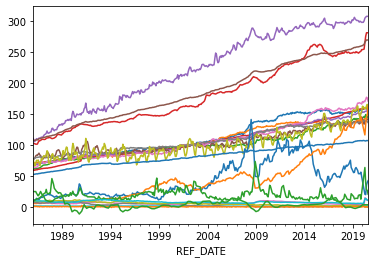

In [6]:
# Plot everything
all_data.plot(legend=False)

In [7]:
"""
Plot correlation matrix between raw features. 
There is a very high degree of correlation between the food CPIs and some other features.
"""

corrmat = all_data.corr()
corrmat.round(2).style.background_gradient(cmap='coolwarm', axis=None)

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,DCOILWTICO,WILL5000IND,VXOCLS,CUSR0000SAF112,CUSR0000SAF113,CPIFABSL,UNRATE,FEDFUNDS,IRLTLT01CAM156N,LRUNTTTTCAM156S,CPALCY01CAM661N,CPGRLE01CAM657N,QCAR368BIS
Bakery and cereal products (excluding baby food),1.00,0.99,0.93,0.97,0.99,0.95,0.96,0.99,0.88,-0.40,0.77,0.87,-0.06,0.99,0.97,0.99,0.14,-0.83,-0.94,-0.55,0.97,-0.18,-0.01
Dairy products and eggs,0.99,1.00,0.91,0.97,0.98,0.92,0.94,0.98,0.85,-0.42,0.81,0.84,-0.05,0.98,0.98,0.99,0.15,-0.83,-0.95,-0.58,0.98,-0.19,0.02
"Fish, seafood and other marine products",0.93,0.91,1.00,0.98,0.97,0.95,0.97,0.95,0.92,-0.12,0.57,0.96,-0.08,0.95,0.92,0.96,-0.05,-0.76,-0.91,-0.54,0.96,-0.19,-0.03
Food purchased from restaurants,0.97,0.97,0.98,1.00,1.00,0.96,0.98,0.98,0.90,-0.27,0.69,0.93,-0.09,0.98,0.97,0.99,0.04,-0.81,-0.95,-0.55,0.99,-0.20,-0.02
Food,0.99,0.98,0.97,1.00,1.00,0.97,0.99,0.99,0.92,-0.30,0.70,0.92,-0.08,0.99,0.96,0.99,0.07,-0.81,-0.94,-0.55,0.99,-0.18,-0.01
"Fruit, fruit preparations and nuts",0.95,0.92,0.95,0.96,0.97,1.00,0.97,0.95,0.93,-0.28,0.62,0.91,-0.10,0.96,0.90,0.95,0.06,-0.77,-0.87,-0.49,0.93,-0.15,0.01
Meat,0.96,0.94,0.97,0.98,0.99,0.97,1.00,0.97,0.93,-0.24,0.63,0.95,-0.10,0.98,0.93,0.97,0.01,-0.77,-0.91,-0.54,0.96,-0.16,0.04
Other food products and non-alcoholic beverages,0.99,0.98,0.95,0.98,0.99,0.95,0.97,1.00,0.89,-0.35,0.73,0.89,-0.08,0.99,0.97,0.99,0.11,-0.81,-0.94,-0.56,0.98,-0.17,-0.01
Vegetables and vegetable preparations,0.88,0.85,0.92,0.90,0.92,0.93,0.93,0.89,1.00,-0.18,0.51,0.91,-0.06,0.89,0.82,0.88,0.04,-0.68,-0.80,-0.44,0.87,-0.12,-0.02
DEXCAUS,-0.40,-0.42,-0.12,-0.27,-0.30,-0.28,-0.24,-0.35,-0.18,1.00,-0.74,-0.09,0.23,-0.34,-0.33,-0.31,-0.45,0.26,0.21,0.17,-0.30,0.02,0.01


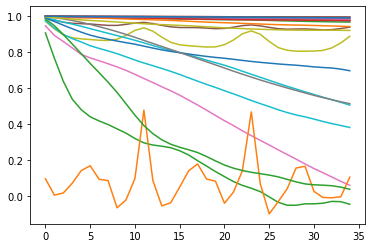

In [8]:
"""
Autocorrelation plot for raw data. 
With the exception of time series that are already differenced, 
the degree of autocorrelation in the raw data is very problematic for linear models. 
"""

autocorrs = {}
for lag in range(1, 36):
    for col_name in all_data.columns:
        if col_name not in autocorrs:
            autocorrs[col_name] = []
        autocorrs[col_name].append(all_data[col_name].autocorr(lag=lag))

autocorrs = pd.DataFrame(autocorrs)
autocorrs.plot(legend=False)

## Forecasting Model Feature Preparation

Prepare data for forecasting models.
- Transform data to year over year change.
- Visualize reconstructed actual cases from daily change to ensure correctness.
- Use tools implemented in models.py to organize data for modelling with scikit-learn regressors.
- From models.py a ForecastPipeline takes care of data splitting and indexing for forecasting with direct models.
- ForecastPipelines also implement **multi-step forecasting** using a collection of independently trained models, one per time step.
- See example below of how to implement a hyperparameter search over various scikit-learn models.

In [9]:
def diff_to_actual(init_rows_df, diff_df, period=12, time_unit='M'):
    """
    A function to map differenced values back to actual values.
    """
    periods = period
    df = init_rows_df
    diffs = diff_df
    restored = df.copy()
    restored = pd.concat((restored, diffs), axis=0)
    for d, val in diffs.iterrows():
        if time_unit == 'MS':
            restored.loc[d] = restored.loc[d - pd.DateOffset(months=periods)] + val
        elif time_unit == 'W':
                restored.loc[d] = restored.loc[d - pd.DateOffset(weeks=periods)] + val
        elif time_unit == 'D':
            restored.loc[d] = restored.loc[d - pd.DateOffset(days=periods)] + val
        else:
            raise Exception("Not implemented.")
    return restored

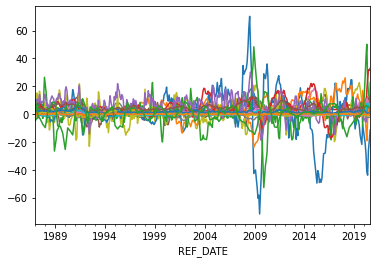

In [10]:
"""
Compute the year-over-year change for all features.
This is considered to be a necessary step for the application of conventional forecasting methods. 
"""
all_data_annual_change = all_data.diff(one_year).dropna()
all_data_annual_change.plot(legend=False)

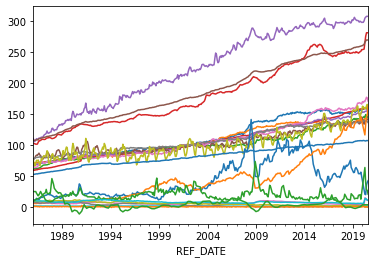

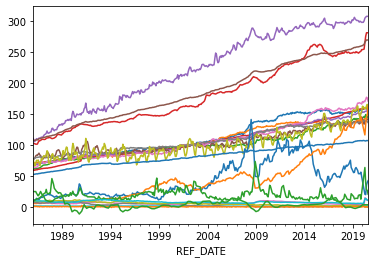

In [11]:
"""
Sanity check: do the annual change convert back to raw values correctly?
"""
init_rows = pd.DataFrame(all_data.iloc[:one_year])
actual_df = diff_to_actual(init_rows, all_data_annual_change, period=one_year, time_unit=frequency)
actual_df.plot(legend=False)
all_data.plot(legend=False)

In [12]:
"""
Plot correlation matrix between annually-differenced features. 
We see much lower correlation than for the raw data. 
"""

corrmat = all_data_annual_change.corr()
corrmat.round(2).style.background_gradient(cmap='coolwarm', axis=None)

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,DCOILWTICO,WILL5000IND,VXOCLS,CUSR0000SAF112,CUSR0000SAF113,CPIFABSL,UNRATE,FEDFUNDS,IRLTLT01CAM156N,LRUNTTTTCAM156S,CPALCY01CAM661N,CPGRLE01CAM657N,QCAR368BIS
Bakery and cereal products (excluding baby food),1.00,0.67,-0.19,0.04,0.57,0.32,0.25,0.49,0.17,0.00,0.05,-0.50,0.37,0.33,0.37,0.70,0.24,-0.32,-0.20,0.14,0.15,0.04,-0.32
Dairy products and eggs,0.67,1.00,-0.22,0.16,0.57,0.32,0.18,0.50,0.22,-0.14,-0.04,-0.48,0.28,0.32,0.35,0.59,0.38,-0.12,-0.23,0.26,0.29,0.05,-0.13
"Fish, seafood and other marine products",-0.19,-0.22,1.00,0.09,0.19,0.13,0.20,0.09,0.25,0.33,-0.34,0.01,0.03,-0.10,-0.20,-0.11,0.10,-0.05,0.05,0.15,-0.02,0.08,0.13
Food purchased from restaurants,0.04,0.16,0.09,1.00,0.49,0.39,0.13,0.18,0.19,-0.05,-0.11,0.03,0.04,0.02,-0.06,0.18,0.24,-0.19,-0.06,0.35,0.56,0.08,-0.06
Food,0.57,0.57,0.19,0.49,1.00,0.71,0.64,0.61,0.66,0.30,-0.39,-0.36,0.33,0.36,0.25,0.57,0.27,-0.24,-0.19,0.34,0.35,0.12,-0.22
"Fruit, fruit preparations and nuts",0.32,0.32,0.13,0.39,0.71,1.00,0.38,0.31,0.35,0.36,-0.39,-0.26,0.25,0.18,0.27,0.35,0.15,-0.26,-0.08,0.27,0.23,0.12,0.01
Meat,0.25,0.18,0.20,0.13,0.64,0.38,1.00,0.24,0.28,0.30,-0.38,-0.09,0.26,0.61,-0.09,0.44,0.09,-0.15,-0.14,0.23,0.14,0.05,-0.11
Other food products and non-alcoholic beverages,0.49,0.50,0.09,0.18,0.61,0.31,0.24,1.00,0.23,0.08,-0.31,-0.42,0.10,0.11,0.09,0.30,0.24,0.02,-0.02,0.15,0.05,0.14,-0.17
Vegetables and vegetable preparations,0.17,0.22,0.25,0.19,0.66,0.35,0.28,0.23,1.00,0.38,-0.28,-0.13,0.23,0.04,0.38,0.20,0.05,-0.02,-0.11,0.11,0.14,0.09,-0.20
DEXCAUS,0.00,-0.14,0.33,-0.05,0.30,0.36,0.30,0.08,0.38,1.00,-0.65,-0.28,0.46,-0.11,-0.16,-0.04,0.10,-0.25,-0.18,0.22,-0.30,0.06,-0.06


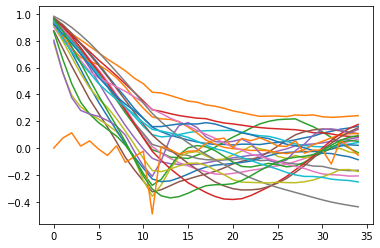

In [13]:
"""
Autocorrelation plot for annually-differenced data. 
This is a significant improvement over non-differenced data, but could still 
be problematic for linear models, especially with small lag values. Further 
or other differencing methods could be applied. 
"""
autocorrs = {}
for lag in range(1, 36):
    for col_name in all_data_annual_change.columns:
        if col_name not in autocorrs:
            autocorrs[col_name] = []
        autocorrs[col_name].append(all_data_annual_change[col_name].autocorr(lag=lag))

autocorrs = pd.DataFrame(autocorrs)
autocorrs.plot(legend=False)

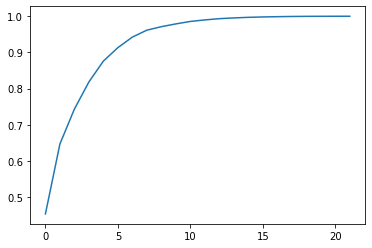

In [14]:
"""
Use PCA for linear/orthogonal decomposition.
"""

from sklearn.decomposition import PCA

variances = []
for c in range(1, len(all_data_annual_change.columns)):
    pca = PCA(c)
    pca.fit(all_data_annual_change)
    expl_var = np.sum(pca.explained_variance_ratio_)
    variances.append(expl_var)

plt.plot(variances)

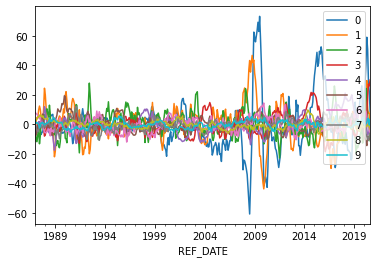

In [15]:
pca = PCA(10)
all_data_annual_change_pca = pd.DataFrame(pca.fit_transform(all_data_annual_change), index=pd.DatetimeIndex(all_data_annual_change.index))
all_data_annual_change_pca.plot()

In [16]:
"""
Sanity check.
"""
corrmat = all_data_annual_change_pca.corr()
corrmat.round(2).style.background_gradient(cmap='coolwarm', axis=None)

,0,1,2,3,4,5,6,7,8,9
0,1.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00
1,-0.00,1.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00
2,0.00,-0.00,1.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
3,-0.00,-0.00,-0.00,1.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
4,0.00,-0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,-0.00
5,0.00,0.00,0.00,0.00,0.00,1.00,-0.00,-0.00,0.00,-0.00
6,-0.00,0.00,0.00,-0.00,0.00,-0.00,1.00,-0.00,0.00,-0.00
7,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,1.00,0.00,0.00
8,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
9,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,1.00


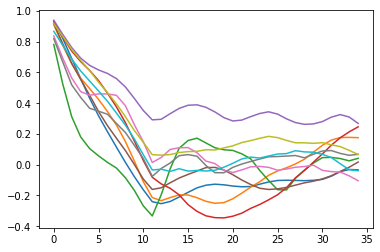

In [17]:
"""
And just to be safe, check PCA-transformed annually-differenced data for autocorrelation.
"""
autocorrs = {}
for lag in range(1, 36):
    for col_name in all_data_annual_change_pca.columns:
        if col_name not in autocorrs:
            autocorrs[col_name] = []
        autocorrs[col_name].append(all_data_annual_change_pca[col_name].autocorr(lag=lag))

autocorrs = pd.DataFrame(autocorrs)
autocorrs.plot(legend=False)

## Train and Validate Models with Optuna (Hyperparameter Optimization)

Let's proceed with using the annually-differenced data, with or without decomposition with PCA. 

We will set up forecasting model training using Optuna for hyperparameter optimization. This is very straightforward and can significantly improve results.

In [18]:
# Set aliases for explanatory and target variables.
expl_names = all_data.columns.to_list()
expl_names

['Bakery and cereal products (excluding baby food)',
 'Dairy products and eggs',
 'Fish, seafood and other marine products',
 'Food purchased from restaurants',
 'Food',
 'Fruit, fruit preparations and nuts',
 'Meat',
 'Other food products and non-alcoholic beverages',
 'Vegetables and vegetable preparations',
 'DEXCAUS',
 'DCOILWTICO',
 'WILL5000IND',
 'VXOCLS',
 'CUSR0000SAF112',
 'CUSR0000SAF113',
 'CPIFABSL',
 'UNRATE',
 'FEDFUNDS',
 'IRLTLT01CAM156N',
 'LRUNTTTTCAM156S',
 'CPALCY01CAM661N',
 'CPGRLE01CAM657N',
 'QCAR368BIS']

In [26]:
"""
Define the scope of the Optuna hyperparameter study here. You can add any additional model types that use a scikit-learn compatible interface.
The pipeline mechanisms used here assume that all point forecasts (e.g. 18 months) are generated by independently trained models that share the same
hyperparameters. An interesting extension would be to allow different hyperparameters for different underlying models. 
"""

# Select a target name - this must be a list with one element. 
target_names = ['Food']

# A dictionary of scikit-learn regressor classes for Optuna to consider.
sk_model_classes = {
#                     'Ridge': Ridge,
                    'RFR': RandomForestRegressor,
                   }

# Some categorical parameter options for certain scikit-learn models
gbr_loss_fns = ['ls', 'lad', 'huber', 'quantile']
max_feature_choices = ['auto', 'sqrt', 'log2']

# Use optuna for feature selection?
select_features = False

# Use PCA-transformed features?
use_pca = True

def objective(trial):

    # The default ForecastPipeline configuration. 
    # Will be modified by Optuna and used to create new ForecastPipeline instances.
    pipeline_params = {
        'expl_names': expl_names,
        'target_names': target_names,
        'include_targets': False,
        'sample_freq': frequency[0],
        'model_type': SKDirect,
        'train_size': 0.6,
        'valid_size': 0.4,
        'model_dict': {
            'model_class': Ridge,
            'model_name': 'Ridge',
            'sample_freq': frequency[0],
            'lag_size': one_year * 3,
            'lead_size': int(one_year * 1.5),
            'sk_params': {                
            }
        }
    }
    
    # Optuna feature selection
    if select_features:
        features = {}
        for expl_name in expl_names:
            features[expl_name] = trial.suggest_categorical(f"f_{expl_name}", [True, False])
        include_features = [f for f, incl in features.items() if incl]
    else:
        include_features = expl_names[:]
    
    # Optuna suggest which regressor to use
    model_class = trial.suggest_categorical("skmt_model_type", sk_model_classes.keys())
    pipeline_params['model_dict']['model_class'] = sk_model_classes[model_class]
    pipeline_params['model_dict']['model_name'] = f"{model_class}"
    
    # Depending on the model selected, Optuna suggest relevant hyperparameters
    if model_class == "Ridge":
        ridge_alpha = trial.suggest_loguniform('skp_alpha', 1e-1, 1e6)
        pipeline_params['model_dict']['sk_params']['alpha'] = ridge_alpha
    
    if model_class == "RFR":
        rfr_max_features = trial.suggest_categorical("skp_max_features", max_feature_choices)
        rfr_max_samples = trial.suggest_uniform("skp_max_samples", 0, 1.0)
        rfr_ccp_alpha = trial.suggest_uniform("skp_ccp_alpha", 0.0, 1.0)
        pipeline_params['model_dict']['sk_params']['max_features'] = rfr_max_features
        pipeline_params['model_dict']['sk_params']['max_samples'] = rfr_max_samples
        pipeline_params['model_dict']['sk_params']['ccp_alpha'] = rfr_ccp_alpha
    
    # Set the lag and lead sizes for the model.
    # Can also be an Optuna tunable parameter.
    lag_size = trial.suggest_int("lag_size", 2, one_year*5)
    lead_size = int(one_year * 1.5)
    pipeline_params['model_dict']['lag_size'] = int(lag_size)
    pipeline_params['model_dict']['lead_size'] = lead_size

    # Create the ForecastPipeline and fit the model, return the validation score squared for comparability to MSE-trained neural nets.
    pipeline = ForecastPipeline(**pipeline_params) 
    if use_pca:
        pipeline.set_data(all_data_annual_change_pca[:], all_data_annual_change[pipeline_params['target_names'][0]]) # Indexing at zero for single column/target to make sklearn happy.
    else:
        pipeline.set_data(all_data_annual_change[include_features], all_data_annual_change[pipeline_params['target_names'][0]]) # Indexing at zero for single column/target to make sklearn happy.
    pipeline.fit()
    return pipeline.valid_score().mean() ** 2

# Create and run the hyperparameter optimization study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, n_jobs=1)

print(f"Best Valid MSE: {study.best_trial.value}")
print(study.best_trial.params)

# Save the results of the study (selected parameters) but not the trained model; do this separately.
pickle.dump(study, open("./optuna_study_results.pkl", "wb"))

[I 2020-09-16 12:31:11,566] Trial 0 finished with value: 3.371959748127733 and parameters: {'skmt_model_type': 'RFR', 'skp_max_features': 'log2', 'skp_max_samples': 0.770994976406292, 'skp_ccp_alpha': 0.8998007529563907, 'lag_size': 56}. Best is trial 0 with value: 3.371959748127733.
[I 2020-09-16 12:31:26,933] Trial 1 finished with value: 3.8169568741819537 and parameters: {'skmt_model_type': 'RFR', 'skp_max_features': 'sqrt', 'skp_max_samples': 0.3842118837377221, 'skp_ccp_alpha': 0.8416647923300412, 'lag_size': 42}. Best is trial 0 with value: 3.371959748127733.
[I 2020-09-16 12:31:48,199] Trial 2 finished with value: 3.077063311157884 and parameters: {'skmt_model_type': 'RFR', 'skp_max_features': 'auto', 'skp_max_samples': 0.206888373141476, 'skp_ccp_alpha': 0.7456913986558776, 'lag_size': 49}. Best is trial 2 with value: 3.077063311157884.
[I 2020-09-16 12:32:21,001] Trial 3 finished with value: 2.446947462902912 and parameters: {'skmt_model_type': 'RFR', 'skp_max_features': 'auto

Best Valid MSE: 2.446947462902912
{'skmt_model_type': 'RFR', 'skp_max_features': 'auto', 'skp_max_samples': 0.46832825927778876, 'skp_ccp_alpha': 0.4549739679132412, 'lag_size': 52}


## Apply Results of Hyperparameter Optimization Study

Here, we are using the optimal hyperparameters to create new models which can be used in ensembles to produce multiple forecasts. This enables (weak) confidence estimation and can also reveal sensitivity of models to differing initial conditions including random seeds. 

In [20]:
# Populate the parameters for a ForecastPipeline with the optimal validation hyperparameters from the Optuna study

if select_features:
    include_features = []
else:
    include_features = expl_names[:]
    
sk_params = {}

lag_size = one_year * 3  # Setting a default value, can be overwritten by Optuna result.

for k, v in study.best_trial.params.items():
    if k.startswith("f_"):
        if v == True:
            include_features.append(k[2:])
    elif k.startswith("skmt_"):
        model_name = v
        model_class = sk_model_classes[v] 
    elif k.startswith("skp_"):
        sk_params[k[4:]] = v
    elif k == 'lag_size':
        lag_size = v
        
if use_pca:
    include_features = list(all_data_annual_change_pca.columns)
        
pipeline_params = {
    'expl_names': include_features,
    'target_names': target_names,
    'include_targets': False,
    'sample_freq': frequency[0],
    'model_type': SKDirect,
    'train_size': 0.6,
    'valid_size': 0.4,
    'model_dict': {
        'model_class': model_class,
        'model_name': model_name,
        'sample_freq': frequency[0],
        'lag_size': lag_size,
        'lead_size': int(one_year * 1.5),
        'sk_params': sk_params
    }
}

pipeline_params

{'expl_names': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'target_names': ['Food'],
 'include_targets': False,
 'sample_freq': 'M',
 'model_type': models.SKDirect,
 'train_size': 0.6,
 'valid_size': 0.4,
 'model_dict': {'model_class': sklearn.linear_model._ridge.Ridge,
  'model_name': 'Ridge',
  'sample_freq': 'M',
  'lag_size': 2,
  'lead_size': 18,
  'sk_params': {'alpha': 8122.300683402399}}}

In [21]:
"""
Fit and save models according to pipeline parameters. 
"""

pipelines = []
for i in range(1):
    pipeline = ForecastPipeline(**pipeline_params)
    if use_pca:
        pipeline.set_data(all_data_annual_change_pca[include_features], all_data_annual_change[pipeline_params['target_names'][0]]) # Indexing at zero for single column/target to make sklearn happy.
    else:
        pipeline.set_data(all_data_annual_change[include_features], all_data_annual_change[pipeline_params['target_names'][0]]) # Indexing at zero for single column/target to make sklearn happy.
    pipeline.fit()
    pickle.dump(pipeline, open(f"./trained_pipelines/{pipeline_params['target_names'][0]}_{pipeline_params['model_dict']['model_name']}_{i}.pkl", 'wb'))
    pipelines.append(pipeline)

In [22]:
if use_pca:
    expl_df = all_data_annual_change_pca[pipeline_params['expl_names']]
else:
    expl_df = all_data_annual_change[pipeline_params['expl_names']]
targets_df = all_data_annual_change[pipeline_params['target_names']]
max_date = "2020-08-01"

In [23]:
forecast_dfs = []
for index, pipeline in enumerate(pipelines):
    forecast_change = pipeline.forecast_by_date(expl_df, max_date=max_date)
    forecast_change = forecast_change.rename(lambda x: f"{x}_{index}", axis=1)
    forecast_dfs.append(forecast_change)

forecast_change = pd.concat(forecast_dfs, axis=1)
forecast_change

,Food_0
2020-09-01,2.97
2020-10-01,2.90
2020-11-01,2.81
2020-12-01,2.69
2021-01-01,2.59
2021-02-01,2.62
2021-03-01,2.60
2021-04-01,2.56
2021-05-01,2.48
2021-06-01,2.43


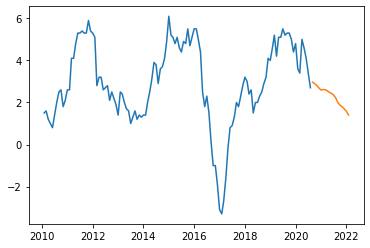

In [24]:
"""
Get historical annual change values.
"""
historical_data = all_data_annual_change[pipeline_params['target_names']]
actual_change = historical_data.loc[historical_data.index > '2010-01-01']
plt.plot(actual_change)
plt.plot(forecast_change)

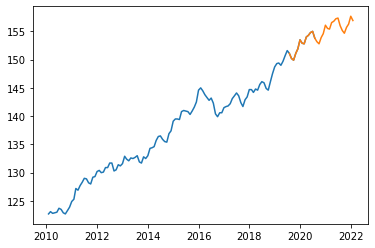

In [25]:
"""
Convert from annual change back to actual.
"""

historical_data = all_data[pipeline_params['target_names']]
actual = historical_data.loc[historical_data.index > '2010-01-01']
plt.plot(actual)

for col_name in forecast_change:
    t_name = col_name.split('_')[0]
    forecast = diff_to_actual(actual.loc[pd.to_datetime(max_date) - pd.DateOffset(years=1):pd.to_datetime(max_date)], forecast_change[col_name].rename(t_name).to_frame(), period=one_year, time_unit=frequency) 
    plt.plot(forecast)
    

## Applying Saved Models

Apply multiple trained models to produce mean forecasts.

In [417]:
trained_pipeline_names = ['Meat_RFR_0.pkl', 'Meat_Ridge_0.pkl']
trained_pipelines = [pickle.load(open(f"./trained_pipelines/{fname}", 'rb')) for fname in trained_pipeline_names]

In [428]:
forecast_dfs = []
for index, pipeline in enumerate(trained_pipelines):
    if use_pca:
        expl_df = all_data_annual_change_pca[pipeline.expl_names]
    else:
        expl_df = all_data_annual_change[pipeline.expl_names]
    targets_df = all_data_annual_change[pipeline.target_names]
    max_date = "2020-08-01"

    forecast_change = pipeline.forecast_by_date(expl_df, max_date=max_date)
    forecast_change = forecast_change.rename(lambda x: f"{x}_{index}", axis=1)
    forecast_dfs.append(forecast_change)

forecast_change = pd.concat(forecast_dfs, axis=1)
forecast_change

,Meat_0,Meat_1
2020-08-01,2.58,2.19
2020-09-01,2.46,1.91
2020-10-01,2.57,1.72
2020-11-01,2.59,1.58
2020-12-01,2.89,1.37
2021-01-01,3.05,1.12
2021-02-01,2.59,0.81
2021-03-01,2.31,0.52
2021-04-01,2.35,0.32
2021-05-01,2.08,0.28


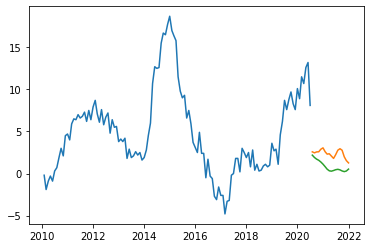

In [431]:
"""
Get historical annual change values.
"""
historical_data = all_data_annual_change[pipeline.target_names]
actual_change = historical_data.loc[historical_data.index > '2010-01-01']
plt.plot(actual_change)
plt.plot(forecast_change)

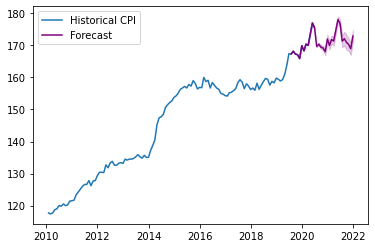

In [458]:
"""
Convert from annual change back to actual.
"""

historical_data = all_data[pipeline.target_names]
actual = historical_data.loc[historical_data.index > '2010-01-01']
plt.plot(actual, label='Historical CPI')

all_forecasts = []
for col_name in forecast_change:
    t_name = col_name.split('_')[0]  # Remove suffixes from column names. 
    forecast = diff_to_actual(actual.loc[pd.to_datetime(max_date) - pd.DateOffset(years=1):pd.to_datetime(max_date)], forecast_change[col_name].rename(t_name).to_frame(), period=one_year, time_unit=frequency) 
    all_forecasts.append(forecast)
    # plt.plot(forecast)

all_forecasts = pd.concat(all_forecasts, axis=1)
mean_forecast = all_forecasts.mean(axis=1)
std_forecast = all_forecasts.std(axis=1)

plt.plot(mean_forecast, color='purple', label='Forecast ')
plt.fill_between(mean_forecast.index, mean_forecast + std_forecast, mean_forecast - std_forecast, color='purple', alpha=0.2)
plt.legend()